# CCF analysis from callings
### Case3-Tumor2

In [1]:
import pandas as pd
import json
import pybedtools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
samples = json.load( open( "../../../cases_ids.json", "rb" ) )
samples['case3']

{'normal': 'AQ5174',
 'tumor1': 'AQ5180',
 'tumor2': 'AQ5186',
 'sex': 'female',
 'kidney': 'AX4954',
 'liver': 'AX4955',
 'pancreas': 'AX4956',
 'heart': 'AX4957',
 'clone1': 'AX4958',
 'clone2': 'AX4961',
 'mother': 'AW8063',
 'father': 'AW8064',
 'lung': 'AX4962',
 'medulla': 'AX4963',
 'spleen': 'AX4964',
 'brain': 'AX4965',
 'bma': 'AX4966'}

## Functions

In [3]:
def cnv_snvs_intersect (cnv_df,snvs_df):
    '''Adds CN information in snvs/indels mafs
    input: cn dataframe from ASCAT output (.cnvs.txt) and snvs/indels dataframe from maf files
    output: dataframe with integrated CN info to vc mafs'''
    
    #Preapre cnv_df
    cnv_bt_df = cnv_df.copy(deep=True)
    cnv_bt_df['CN'] = cnv_bt_df['nMajor']+cnv_bt_df['nMinor']
    cnv_bt_df['chr'] = 'chr' + cnv_bt_df['chr']

    #Prepare snvs_df
    snvs_bt_df = snvs_df.copy(deep=True)
    snvs_bt_df['POS2'] = snvs_bt_df['POS'] + 1
    snvs_bt_df = snvs_bt_df[['#CHROM','POS','POS2','REF','ALT']]

    #pybedtools cnv + snvs
    cnv_bt = pybedtools.BedTool.from_dataframe(cnv_bt_df)
    snvs_bt = pybedtools.BedTool.from_dataframe(snvs_bt_df)

    cnv_and_snvs = cnv_bt.intersect(snvs_bt)

    #Pass intersection to dataframe
    snvs_cnv_df = cnv_and_snvs.to_dataframe()
    snvs_cnv_df = snvs_cnv_df.rename(columns={'chrom':'#CHROM','start':'POS','end':'POS2',
                                              'name':'nMinor','score':'nMajor','strand':'CN'})
    snvs_cnv_df = snvs_cnv_df.drop(columns=['POS2'])

    #Merge intersect with snvs_df
    snvs_cnv_df = pd.merge(snvs_df,snvs_cnv_df,how='left')
    return snvs_cnv_df

def calculate_VAF(reads_alt,reads_ref):
    '''Calculate VAF from number of reads
    input: number of reads alternate allele, number of reads reference allele
    output: variant allele frequency'''
    if reads_alt == reads_ref == 0:
        return 0
    else:
        vaf = round (reads_alt/(reads_alt+reads_ref),3)
        return vaf

def calculate_ccf (vaf,cnv,purity):
    '''Calculate CCF from VAF, CN and purity
    input: variant allele frequency, copy number, purity(.purityploidy.txt file from ASCAT)
    output: cancer cell fraction'''
    ccf = vaf*(purity*cnv+ (1-purity)*2)/purity
    return ccf

def final_dataframe (path_cnv,path_purity,path_caller,vc,t,purity='purple'):
    '''Reads vc mafs and ASCAT output, makes intersect snvs and CN and adds columns calculated 
    with VAF and CCF
    input: patient, tumor sample id, normal sample id and caller type
    output: final dataframe with CN, VAF and CCF information added'''
    
    #Read vc mafs and ASCAT output
    cnv_df = pd.read_csv(path_cnv,sep='\t')      
    if purity == 'ascat':
        purity = pd.read_csv(path_purity,sep='\t')
        #Get purity
        purity = purity['AberrantCellFraction'][0]
    elif purity == 'purple':
        purity = pd.read_csv(path_purity,sep='\t')
        #Get purity
        purity = purity['purity'][0]
    
    if vc == 'mutect':
        snvs_df = pd.read_csv(path_caller,sep='\t')
    elif vc =='strelka':
        snvs_df = pd.read_csv(path_caller,sep='\t')
    elif vc == 'sage':
        snvs_df = pd.read_csv(path_caller,sep='\t')
    elif vc == 'intersect':
        snvs_df = pd.read_csv(path_caller,sep='\t')
    else:
        print('Specify variant caller: mutect, strelka, sage, intersect')
    
    #Get df with cn and snv intersect
    df = cnv_snvs_intersect(cnv_df,snvs_df)
    
    #Calculate AF and CCF
    df['t_AF'] = df.apply(lambda row: calculate_VAF(row['t_alt_reads'],row['t_ref_reads']),axis=1)
    df['n_AF'] = df.apply(lambda row: calculate_VAF(row['n_alt_reads'],row['n_ref_reads']),axis=1)
    df['t_CCF'] = df.apply(lambda row: calculate_ccf(row['t_AF'],row['CN'],purity),axis=1)
    df['n_CCF'] = df.apply(lambda row: calculate_ccf(row['n_AF'],row['CN'],purity),axis=1)
    df['purity'] = purity
    
    return df

### Case 3

In [5]:
pt = 'case3'

#Clone1
tumor = samples[pt]['clone1']
normal = samples[pt]['normal']

#This commented line is pointing to the original data
# path_to_sarek = '/workspace/datasets/sjd_seq/sarek_results/pt1/results/'

#Adapt the path accordingly
path_to_sarek = '/path/to/sarek/output/'

path_cnv = path_to_sarek+'variant_calling/ascat/AX4958_vs_AQ5174/AX4958_vs_AQ5174.cnvs.txt'
path_purity = path_to_sarek+'variant_calling/ascat/'+tumor+'_vs_'+normal+'/'+tumor+'_vs_'+normal+'.purityploidy.txt'
path_caller = './output/case3/AX4958_vs_AQ5174/vcf_processing/strelka/AX4958_vs_AQ5174_process.maf.gz'
case3_c1_strelka_df = final_dataframe(path_cnv,path_purity,path_caller,'strelka','t2',purity='ascat')

#Clone2
tumor = samples[pt]['clone2']

#This commented line is pointing to the original data
# path_to_sarek = '/workspace/datasets/sjd_seq/sarek_results/pt1/results/'

#Adapt the path accordingly
path_to_sarek = '/path/to/sarek/output/'

path_cnv = path_to_sarek+'variant_calling/ascat/AX4961_vs_AQ5174/AX4961_vs_AQ5174.cnvs.txt'
path_purity = path_to_sarek+'variant_calling/ascat/'+tumor+'_vs_'+normal+'/'+tumor+'_vs_'+normal+'.purityploidy.txt'
path_caller = './output/case3/AX4961_vs_AQ5174/vcf_processing/strelka/AX4961_vs_AQ5174_process.maf.gz'
case3_c2_strelka_df = final_dataframe(path_cnv,path_purity,path_caller,'strelka','t2',purity='ascat')

In [6]:
case3_c1_strelka_df.columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'NORMAL', 'TUMOR', 't_AF', 'n_AF', 'DP_tumor', 't_alt_reads',
       't_ref_reads', 'DP_normal', 'n_alt_reads', 'n_ref_reads', 'mut_type',
       'GT_normal', 'GT_tumor', 'nMinor', 'nMajor', 'CN', 't_CCF', 'n_CCF',
       'purity'],
      dtype='object')

## Plots

In [7]:
samples_strelka_list = [case3_c1_strelka_df,case3_c2_strelka_df]

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


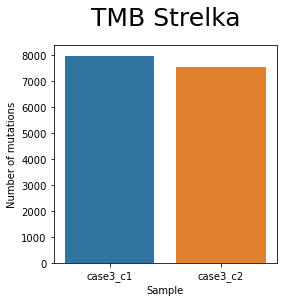

In [8]:
import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

tum_burden = []
for sample in samples_strelka_list:
    sample_name = retrieve_name(sample)[0].split('_strelka_df')[0]
    sample_final = []
    sample_final.append(sample_name)
    sample_final.append(len(sample))
    tum_burden.append(sample_final)
tum_burden_df = pd.DataFrame(tum_burden,columns=['Sample','Number of mutations'])
plt.figure(figsize=(4,4))
sns.barplot(tum_burden_df['Sample'],tum_burden_df['Number of mutations'])
plt.title('TMB Strelka',size=25,pad=20)
pos=1.5

### Density plots

In [9]:
def get_ccf_threshold (data,sample,title):
    '''get threshold for clonal fraction of the variants
    input: data table per sample
    output: float, t_CCF value'''
    purity = data['purity'][0]
    def slope(data_y,data_x,i):
        slope = (data_y[i+1] - data_y[i]) / (data_x[i+1] - data_x[i])
        return slope
    y_var='t_CCF'
    xlim=3
    data = data[(~data[y_var].isnull())&(data['t_CCF']<xlim)]
    data = data[y_var]
    fig, ax = plt.subplots()
    fig.set_size_inches(4, 2)
    ax = sns.distplot(data,rug=True,bins=50)
    data_x, data_y = ax.lines[0].get_data()

    poss = []
    for i in range(len(data_y)):
        if i == 0 or i == (len(data_y)-1):
            pass
        else:
            if sample == 'case3_t2':
                if  slope(data_y,data_x,i)<0.8 and slope(data_y,data_x,i)>0.7:
                    pos = i
                    poss.append(pos)
            elif sample == 'case2_t2':
                if  slope(data_y,data_x,i)<-0.8 and slope(data_y,data_x,i)>-0.9:
                    pos = i
                    poss.append(pos)
            else:
                if (data_y[i] < data_y[i+1]) and (data_y[i] < data_y[i-1]):
                    poss.append(i)

    poss = [pos for pos in poss if data_x[pos] <1]
    if poss == []:
        pos = 0
    else:
        pos = max(poss)
        
    plt.axhline(y = data_y[pos],color='k',linewidth=1,linestyle='--')
    plt.axvline(x = data_x[pos],color='k',linewidth=1,linestyle='--')
    plt.text(data_x[pos]+0.1,data_y.max(),'Clonal',size=14)
    plt.text(data_x.max()*0.7,data_y.max(),'Purity = '+str(purity))
    ax.set_title(title,size=20,pad=20)

    return data_x[pos]

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

{'case3_c1': 0.7607865512511622, 'case3_c2': 0.5709676625152742}

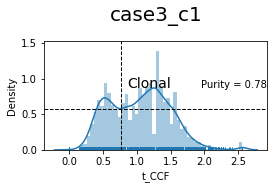

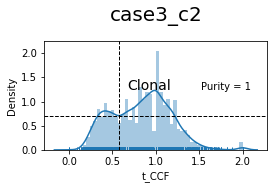

In [10]:
thresholds = {}

data = case3_c1_strelka_df
sample = pt + '_c1'
threshold = get_ccf_threshold(data,sample,sample)
thresholds[sample] = threshold

data = case3_c2_strelka_df
sample = pt + '_c2'
threshold = get_ccf_threshold(data,sample,sample)
thresholds[sample] = threshold
thresholds

In [11]:
thresholds

{'case3_c1': 0.7607865512511622, 'case3_c2': 0.5709676625152742}

In [12]:
json.dump(thresholds, open( "./ccf_thresholds_case3_t2_clones.json", "w" ) )